In [116]:
import networkx as nx
import numpy as np
import pysmiles
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from collections import defaultdict
from typing import List, Optional, Tuple, Union
# from rdkit.Chem.rdmolops import GetAdjacencyMatrix

import torch

from torch_geometric.utils import convert
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader



In [105]:
benzene = "C1=CC=CC=C1"
anisole = "COC1=CC=CC=C1"
bucky = 'C12=C3C4=C5C6=C1C7=C8C9=C1C%10=C%11C(=C29)C3=C2C3=C4C4=C5C5=C9C6=C7C6=C7C8=C1C1=C8C%10=C%10C%11=C2C2=C3C3=C4C4=C5C5=C%11C%12=C(C6=C95)C7=C1C1=C%12C5=C%11C4=C3C3=C5C(=C81)C%10=C23'


In [106]:
weight_map = {
    'SINGLE': 1,
    'AROMATIC': 1.5,
    'DOUBLE': 2,
    'TRIPLE': 3
}

In [144]:
def mol_to_graph(mol, data=None):
    if data:
        G = nx.Graph(
            bbb=data['BBB+/BBB-'], 
            y=1 if data['BBB+/BBB-']=="BBB+" else 0, 
            compound=data['compound_name']
        )
    else:
        G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), atomic_num=atom.GetAtomicNum(), is_aromatic=atom.GetIsAromatic(), symbol=atom.GetSymbol())

    for bond in mol.GetBonds():
        bond_weight = weight_map[str(bond.GetBondType())]
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType(), weight=bond_weight)
    
    return G

In [145]:
def draw_mol(G):
    pos = nx.spring_layout(G)
    elements = nx.get_node_attributes(G, name="symbol")
    labels = nx.get_edge_attributes(G,'weight')

    nx.draw(G, pos, with_labels=True, labels=elements)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

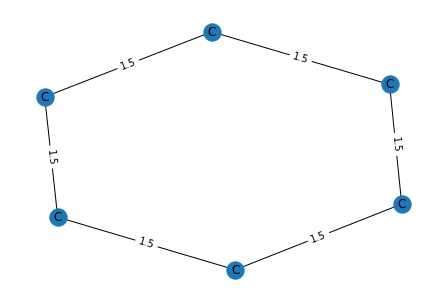

In [146]:
mol = Chem.MolFromSmiles(benzene)
G = mol_to_graph(mol, None)
draw_mol(G)

In [147]:
data = pd.read_csv("B3DB/B3DB/B3DB_classification.tsv", sep="\t")
data_ext = pd.read_csv("B3DB/B3DB/B3DB_classification_extended.tsv.gz", sep="\t", compression="gzip")

/var/folders/wz/sl0zwknj6q3bt1yxsdtmc0mr0000gn/T/ipykernel_2203/283256523.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ext = pd.read_csv("B3DB/B3DB/B3DB_classification_extended.tsv.gz", sep="\t", compression="gzip")


In [154]:
row = data.sample().iloc[0]

In [149]:
def data_from_smiles(smiles, display=False):
    mol = Chem.MolFromSmiles(smiles)
    G = mol_to_graph(mol)
    if display:
        display(mol)
        draw_mol(G)
    return convert.from_networkx(G)

CC(=CCCN1CCC2(CC1)C(=O)NCN2c1ccccc1)c1ccc(F)cc1 spirilene BBB+


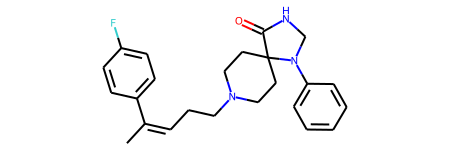

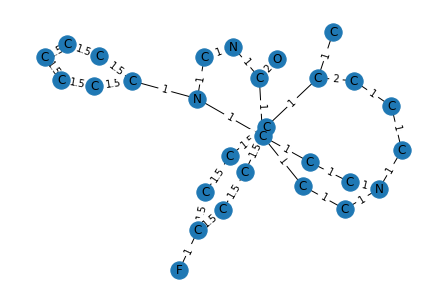

bbb: BBB+
y: 1
compound: spirilene


In [156]:
print(row['SMILES'], row['compound_name'], row['BBB+/BBB-'])

mol = Chem.MolFromSmiles(row['SMILES'])
display(mol)

G = mol_to_graph(mol, dict(row))
draw_mol(G)
for key, value in G.graph.items():
    print(f"{key}: {value}")

In [186]:
def from_networkx(G):
    G = nx.convert_node_labels_to_integers(G)
    edges = list(G.edges)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = defaultdict(list)
    data['edge_index'] = edge_index.view(2, -1)
    for key, value in G.graph.items():
        data[key] = value
    xs = []
    for i, (_, node_data) in enumerate(G.nodes(data=True)):
        for key, value in node_data.items():
            data[key].append(value)
    for i, (_, _, edge_data) in enumerate(G.edges(data=True)):
        for key, value in edge_data.items():
            data[key].append(value)
                            
    for key in ["atomic_num", "is_aromatic"]:
        xs.append(data[key])
        data['x'] = torch.tensor(xs)

    return Data.from_dict(data)

In [187]:
print(from_networkx(G))

Data(x=[2, 29], edge_index=[2, 32], y=1, bbb='BBB+', compound='spirilene', atomic_num=[29], is_aromatic=[29], symbol=[29], bond_type=[32], weight=[32])


6814 COC1CC(CC(C)C2CC(=O)[C@H](C)C=C(C)[C@H](O)C(OC)C(=O)C(C)CC(C)/C=C/C=C/C=C(\C)[C@@H](OC)CC3CC[C@@H](C)[C@@](O)(O3)C(=O)C(=O)N3CCCCC3C(=O)O2)CC[C@@H]1OC(=O)C(C)(CO)CO
temsirolimus BBB+


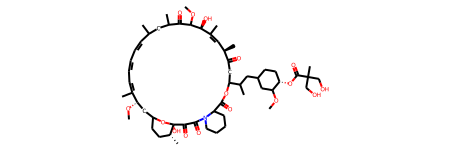

TypeError: string indices must be integers

In [178]:
for i, row in data.sample(10).iterrows():
    print(i, row['SMILES'])
    print(row['compound_name'], row['BBB+/BBB-'])
    mol = Chem.MolFromSmiles(row['SMILES'])
    display(mol)
    G = mol_to_graph(mol, row['BBB+/BBB-'])
    draw_mol(G)